In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import shap
import graphviz



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score

1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.
   > Датасет должен содержать как минимум количественные признаки. Если категориальных нет, то пропустить пункты с временным убиранием категориальных признаков. Желательно наличие обоих типов признаков в датасете.


In [2]:
# Загрузка датасета
df = pd.read_csv("../dataset/Score.csv")

2. Датасет и подготовка данных:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Нормализовать численные данные.
   - Разбить выборку на обучающую и тестовую.
     > Из датафреймов обучающей и тестовой выборки необходимо сформировать два набора обучающей и тестовой выборок: с закодированными категориальными признаками и с категориальными признаками без обработки.

In [3]:
df.describe()

,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Utilization_Ratio,Credit_History_Age,Amount_invested_monthly,Monthly_Balance,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Monthly_Inhand_Salary,Changed_Credit_Limit,Outstanding_Debt,Total_EMI_per_month
count,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000,99960.000000
mean,21.095718,13.336345,5.774570,32.284544,221.122819,193.665219,403.445100,33.269228,50498.704153,5.368868,5.532853,14.535174,3.533974,4196.814288,10.396953,1426.514966,105.565802
std,14.827414,6.269964,3.862224,5.116888,99.696084,194.782737,214.387092,10.762371,38294.243161,2.591668,2.067698,8.741047,2.446156,3186.518163,6.510846,1155.252504,125.820983
min,0.000000,0.000000,0.000000,20.000000,1.000000,0.000000,0.007760,14.000000,7005.930000,0.000000,0.000000,1.000000,0.000000,303.645417,0.500000,0.230000,0.000000
25%,10.000000,9.000000,3.000000,28.052051,144.000000,73.708522,270.317007,24.000000,19338.480000,3.000000,4.000000,7.000000,2.000000,1626.594167,5.500000,566.080000,29.054273
50%,18.000000,14.000000,5.000000,32.305470,219.000000,129.342067,337.237873,33.000000,36996.830000,5.000000,5.000000,13.000000,3.000000,3091.386667,9.340000,1166.470000,66.058063
75%,28.000000,18.000000,8.000000,36.496305,302.000000,234.323706,471.904834,42.000000,71681.400000,7.000000,7.000000,20.000000,5.000000,5957.715000,14.680000,1948.200000,145.584994
max,67.000000,28.000000,29.000000,50.000000,404.000000,1977.326102,1602.040519,56.000000,179987.280000,10.000000,11.000000,34.000000,9.000000,15204.633333,29.980000,4998.070000,1779.103254


In [4]:

df = df.dropna()

y = df['Credit_Score']

X = df.drop(columns=['Credit_Score'])

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_num = X.select_dtypes(include=['int64', 'float64'])
X_cat = X.select_dtypes(exclude=['int64', 'float64'])

scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns)

X_cat_encoded = pd.get_dummies(X_cat, drop_first=True)

X_final_encoded = pd.concat([X_num_scaled, X_cat_encoded], axis=1)

X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(
    X_final_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_final_raw = pd.concat([X_num_scaled, X_cat], axis=1)
X_train_raw, X_test_raw, _, _ = train_test_split(
    X_final_raw, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

3. Для каждого из классификаторов ($AdaBoost$, $GradientBoostingClassifier$, $XGBoost$, $CatBoost$):
   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.
     > Как минимум основных: `n_estimators`/`iterations`, `learning_rate`, `depth`, параметры регуляризации $L^1$, $L^2$. Для ускорения вычислений можно сразу с заданным значением `early_stopping_rounds` &ndash; тогда понадобится еще выделить валидационный датасет ($XGBoost$) или задать значение `train_size` у $CatBoost$ (часть обучающей выборки пойдет в валидационный набор).
   - Обучить модели $XGBoost$ и $CatBoost$ с найденными гиперпараметрами на обучающей выборке с категориальными признаками "как есть".
   - Итого получить 6 обученных моделей.
   - Вывести метрики на тестовом наборе (как минимум `classification_report`, другие по желанию).
   - Сравнить модели, выбрать лучшую.
     > Ожидаемый результат &ndash; $XGBoost$/$CatBoost$.

In [7]:
models_params = {
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42, algorithm="SAMME"),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1, 1]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='mlogloss', random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5],
            "reg_alpha": [0, 0.1],
            "reg_lambda": [1, 10]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42, train_dir="temp_catboost_dir"),
        "params": {
            "iterations": [50, 100],
            "learning_rate": [0.01, 0.1],
            "depth": [3, 5],
            "l2_leaf_reg": [1, 3]
        }
    }
}

best_models = {}

In [8]:
for name, mp in models_params.items():
    print(f"\nЗапуск GridSearchCV для {name}...")
    model = mp["model"]
    params = mp["params"]

    if name == "CatBoost":
        grid = GridSearchCV(
            estimator=model,
            param_grid=params,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            error_score='raise'
        )
        grid.fit(X_train_raw, y_train, cat_features=X_cat.columns.tolist())
    else:
        grid = GridSearchCV(
            estimator=model,
            param_grid=params,
            cv=3,
            scoring='accuracy',
            n_jobs=-1
        )
        grid.fit(X_train_encoded, y_train)

    print(f"Лучшие параметры для {name}: {grid.best_params_}")
    best_models[name] = grid.best_estimator_

print("\nОбучение XGBoost и CatBoost с лучшими гиперпараметрами...")

xgb_best = best_models["XGBoost"]
xgb_best.fit(X_train_encoded, y_train)

cat_best = best_models["CatBoost"]
cat_best.fit(X_train_raw, y_train, cat_features=X_cat.columns.tolist())

best_models["XGBoost"] = xgb_best
best_models["CatBoost"] = cat_best

print("\nОтчеты классификации на тестовой выборке:")

for name, model in best_models.items():
    print(f"\n{name}:")

    X_test_used = X_test_raw if name == "CatBoost" else X_test_encoded
    y_pred = model.predict(X_test_used)
    print(classification_report(y_test, y_pred, target_names=le.classes_))


Запуск GridSearchCV для AdaBoost...
Лучшие параметры для AdaBoost: {'learning_rate': 1, 'n_estimators': 100}

Запуск GridSearchCV для GradientBoosting...
Лучшие параметры для GradientBoosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Запуск GridSearchCV для XGBoost...
Лучшие параметры для XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1}

Запуск GridSearchCV для CatBoost...
Лучшие параметры для CatBoost: {'depth': 5, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

Обучение XGBoost и CatBoost с лучшими гиперпараметрами...

Отчеты классификации на тестовой выборке:

AdaBoost:
              precision    recall  f1-score   support

        Good       0.52      0.65      0.58      3565
        Poor       0.65      0.54      0.59      5797
    Standard       0.69      0.69      0.69     10630

    accuracy                           0.64     19992
   macro avg       0.62      0.63      0.62     19992
weight

4. Важность признаков:
   - С использованием `shap.TreeExplainer` получить $SHAP$-значения для лучшей модели.
   - Построить график `shap.plots.force` для одного объекта выборки и для среза произвольного размера.
   - Построить график `shap.plots.bar` для одного объекта выборки.
   - Построить график `shap.plots.waterfall` для одного объекта выборки.
   - Построить 2 графика `shap.plots.scatter` для какого-нибудь признака. На одном раскрасить относительно себя, на втором &ndash; относительно другого признака.
   - Построить график `shap.plots.beeswarm` для всех признаков.
   - Построить график `shap.plots.bar` для всех признаков.
   - На основании двух последних графиков и/или используя `feature_importance` отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.
   - Сравнить метрики до и после фильтрации.
   - Визуализировать полученное дерево решений.

In [9]:
shap.initjs()

In [10]:
best_model_name = "CatBoost"
best_model = best_models[best_model_name]

In [11]:
best_model = best_models["CatBoost"]

X_data = X_test_raw

explainer = shap.TreeExplainer(best_model)

shap_values = explainer(X_data)

sample_idx = 0
class_idx = 0

In [12]:
# Force plot для одного объекта и класса
shap.plots.force(
    shap.Explanation(
        values=shap_values.values[sample_idx, :, class_idx],
        base_values=explainer.expected_value[class_idx],
        data=X_data.iloc[sample_idx]
    )
)

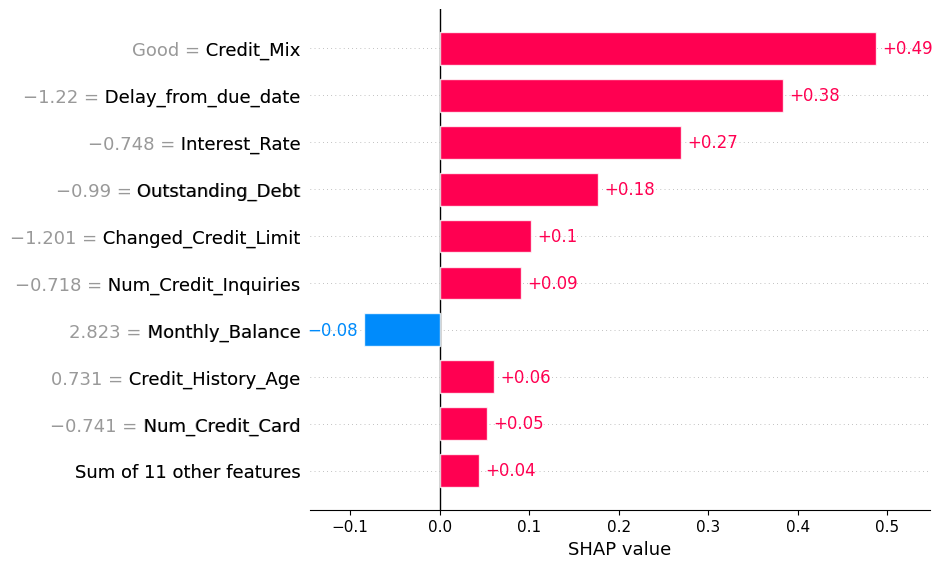

In [11]:
shap.plots.bar(
    shap.Explanation(
        values=shap_values.values[sample_idx, :, class_idx],
        base_values=explainer.expected_value[class_idx],
        data=X_data.iloc[sample_idx]
    )
)

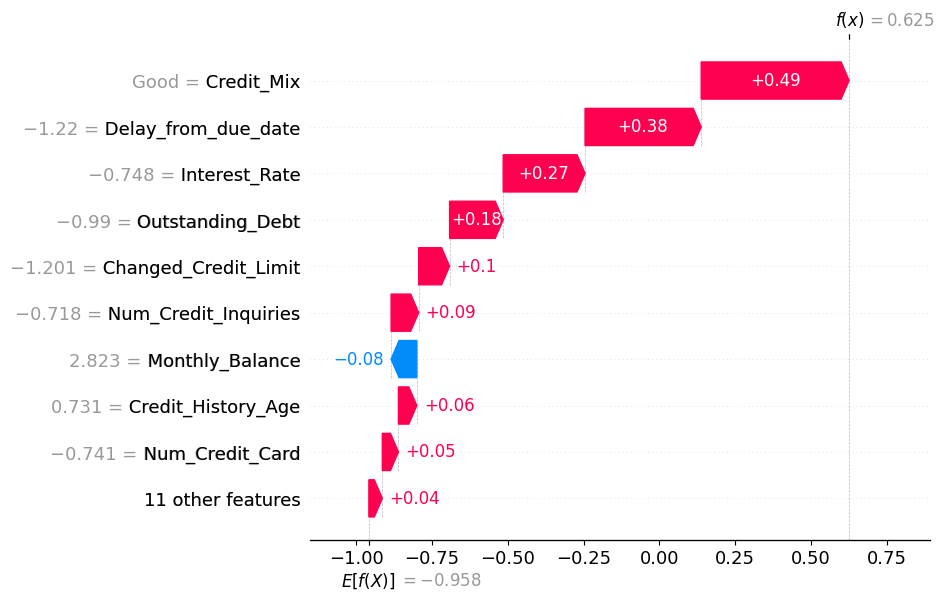

In [12]:
# 8. Waterfall plot для одного объекта и класса
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values.values[sample_idx, :, class_idx],
        base_values=explainer.expected_value[class_idx],
        data=X_data.iloc[sample_idx]
    )
)

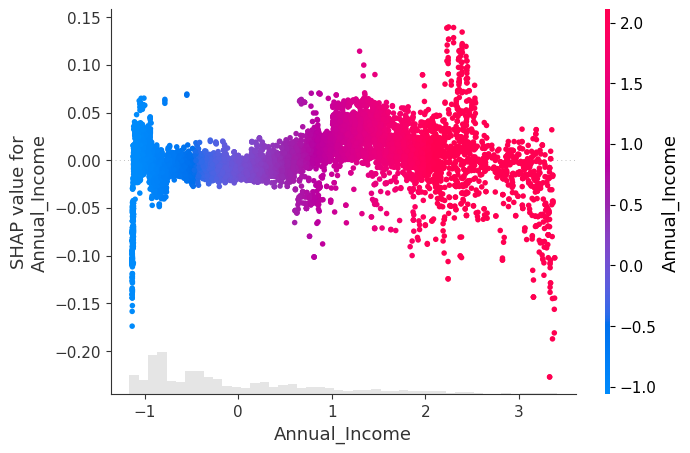

In [13]:
# Scatter plot по признаку 'Annual_Income' и цвет по нему же
shap.plots.scatter(
    shap_values[:, X_data.columns.get_loc("Annual_Income"), class_idx],
    color=shap_values[:, X_data.columns.get_loc("Annual_Income"), class_idx]
)

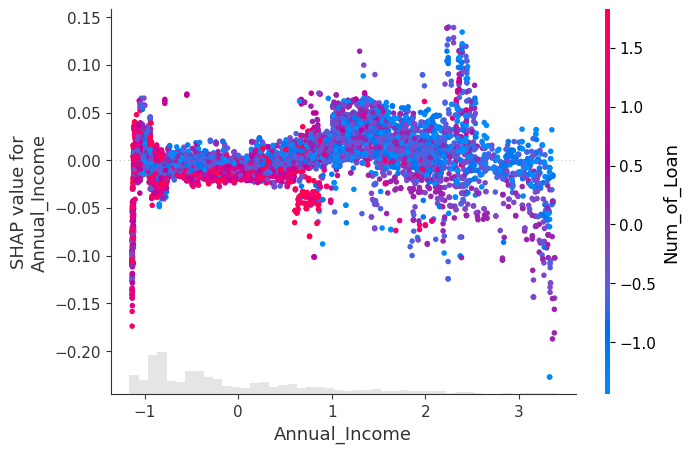

In [14]:
# Scatter plot по признаку 'Annual_Income' и цвет по другому признаку 'Num_of_Loan'
shap.plots.scatter(
    shap_values[:, X_data.columns.get_loc("Annual_Income"), class_idx],
    color=shap_values[:, X_data.columns.get_loc("Num_of_Loan"), class_idx]
)

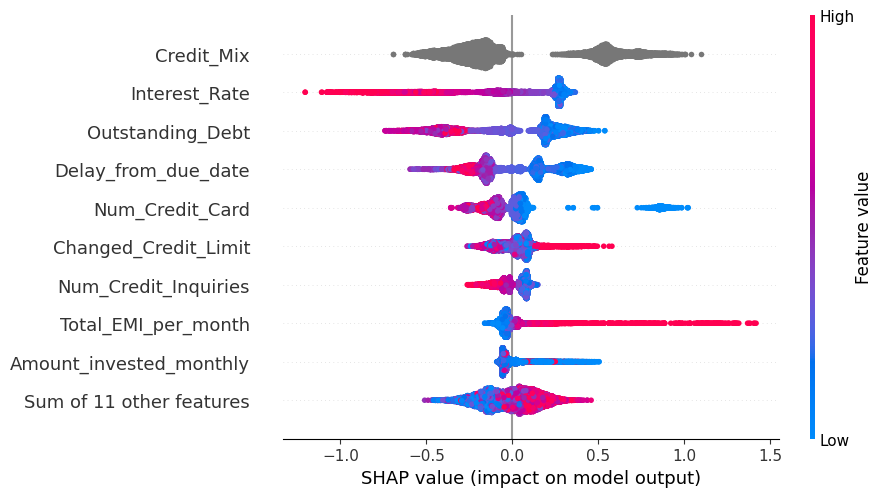

In [15]:
# Beeswarm plot — важность признаков по всей выборке и выбранному классу
shap.plots.beeswarm(
    shap.Explanation(
        values=shap_values.values[:, :, class_idx],
        base_values=np.repeat(explainer.expected_value[class_idx], len(X_data)),
        data=X_data
    )
)

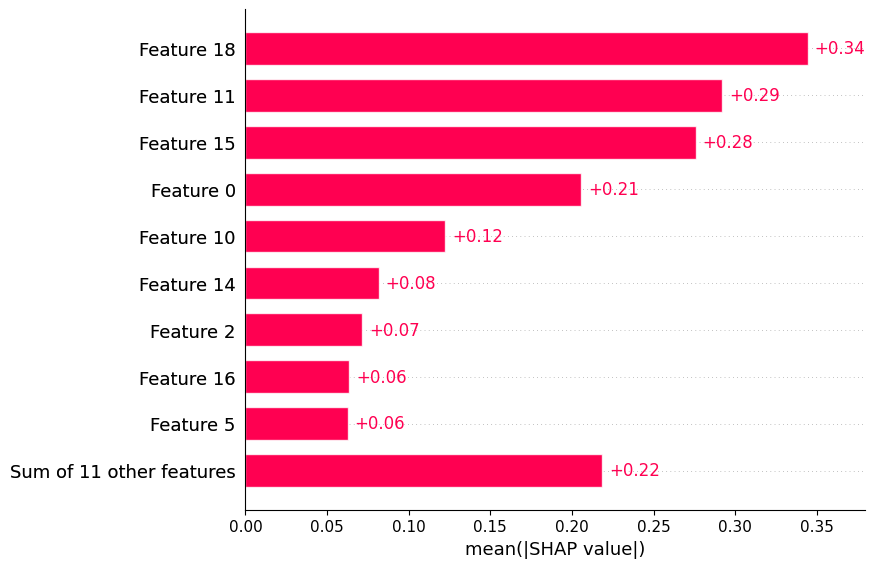

In [16]:
# Bar plot важности признаков по всей выборке и выбранному классу
shap.plots.bar(
    shap.Explanation(
        values=shap_values.values[:, :, class_idx],
        base_values=np.repeat(explainer.expected_value[class_idx], len(X_data)),
        data=X_data
    )
)

In [17]:
# Выбор важных признаков (на основе средней абсолютной SHAP важности для выбранного класса)
importances = np.abs(shap_values.values[:, :, class_idx]).mean(axis=0)
feature_names = X_data.columns
important_features = feature_names[importances > np.percentile(importances, 50)]


In [18]:
# Отфильтруем данные
X_filtered = X_data[important_features]

In [19]:
# Переобучение модели на выбранных признаках
cat_filtered = CatBoostClassifier(**best_model.get_params())
cat_filtered.set_params(verbose=0)

cat_filtered.fit(X_filtered, y_test, cat_features=list(set(important_features) & set(X_cat.columns)))


In [20]:
# Оценка модели
y_pred_filtered = cat_filtered.predict(X_filtered)
print("Классификация после отбора признаков:")
print(classification_report(y_test, y_pred_filtered, target_names=le.classes_))

Классификация после отбора признаков:
              precision    recall  f1-score   support

        Good       0.57      0.69      0.62      3565
        Poor       0.73      0.64      0.68      5797
    Standard       0.76      0.75      0.76     10630

    accuracy                           0.71     19992
   macro avg       0.68      0.69      0.69     19992
weighted avg       0.72      0.71      0.71     19992



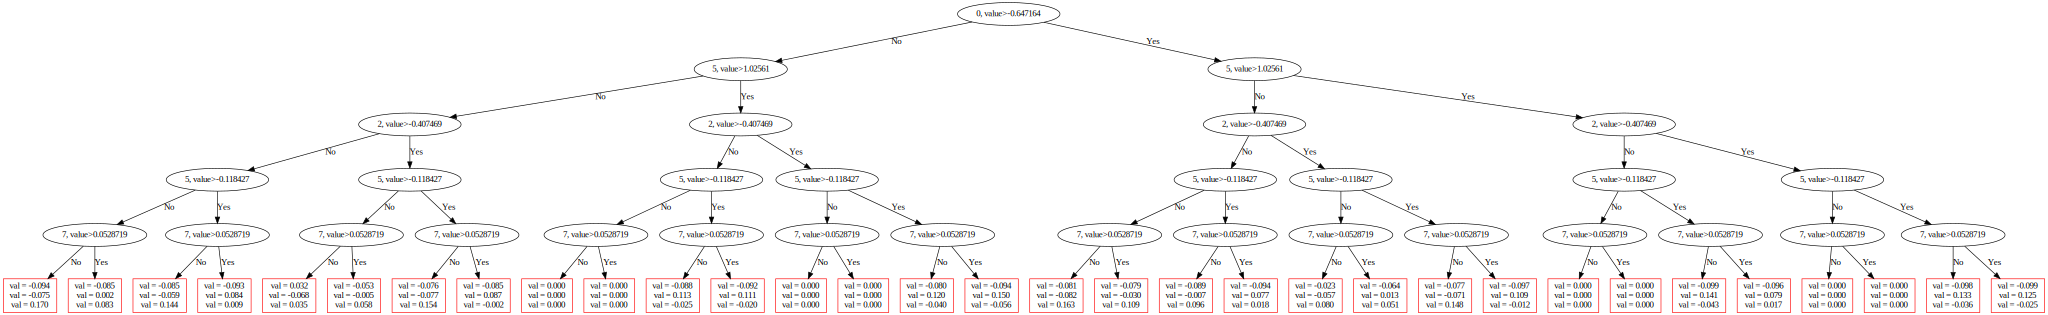

In [21]:
# Визуализация первого дерева
cat_filtered.plot_tree(tree_idx=0)

5. Регрессия:
   - С использованием `GridSearchCV`/`grid_search` осуществить подбор гиперпараметра модели линейной регрессии с использованием $XGBoost$ или $CatBoost$.
     > [xgboost.XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) в $XGBoost$, [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) в $CatBoost$. В целом, можно выбрать новый таргет из уже полученного разбиения на обучающую и тестовыую выборки из пункта 2.
   - Вывести метрики $MSE$, $MAE$ и $R^2$ на тестовом наборе.
   - Переобучить модель на отфильтрованном наборе признаков из пункта 4.
   - Сравнить метрики до и после фильтрации.

In [24]:
target_regression = 'Annual_Income'

X_reg = df.drop(columns=['Credit_Score', target_regression])
y_reg = df[target_regression]

X_reg_num = X_reg.select_dtypes(include=['int64', 'float64'])
X_reg_cat = X_reg.select_dtypes(exclude=['int64', 'float64'])
X_reg_num_scaled = pd.DataFrame(scaler.fit_transform(X_reg_num), columns=X_reg_num.columns)
X_reg_cat_encoded = pd.get_dummies(X_reg_cat, drop_first=True)
X_reg_encoded = pd.concat([X_reg_num_scaled, X_reg_cat_encoded], axis=1)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_encoded, y_reg, test_size=0.2, random_state=42
)

xgb_reg = XGBRegressor(random_state=42)
xgb_params = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 10]
}

xgb_grid = GridSearchCV(
    estimator=xgb_reg,
    param_grid=xgb_params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
xgb_grid.fit(X_train_reg, y_train_reg)
best_xgb_reg = xgb_grid.best_estimator_
y_pred_xgb = best_xgb_reg.predict(X_test_reg)

print("XGBoost Regressor Metrics:")
print("MSE:", mean_squared_error(y_test_reg, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test_reg, y_pred_xgb))
print("R^2:", r2_score(y_test_reg, y_pred_xgb))

XGBoost Regressor Metrics:
MSE: 3500738.669965438
MAE: 1532.7278369765872
R^2: 0.9975928253569387


In [25]:
X_reg_raw = pd.concat([X_reg_num_scaled, X_reg_cat], axis=1)
X_train_raw_reg, X_test_raw_reg, y_train_raw_reg, y_test_raw_reg = train_test_split(
    X_reg_raw, y_reg, test_size=0.2, random_state=42
)

cat_reg = CatBoostRegressor(verbose=0, random_state=42)
cat_params = {
    "iterations": [50, 100],
    "learning_rate": [0.01, 0.1],
    "depth": [3, 5],
    "l2_leaf_reg": [1, 3]
}

cat_grid = GridSearchCV(
    estimator=cat_reg,
    param_grid=cat_params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
cat_grid.fit(X_train_raw_reg, y_train_raw_reg, cat_features=X_cat.columns.tolist())
best_cat_reg = cat_grid.best_estimator_
y_pred_cat = best_cat_reg.predict(X_test_raw_reg)

print("\nCatBoost Regressor Metrics:")
print("MSE:", mean_squared_error(y_test_raw_reg, y_pred_cat))
print("MAE:", mean_absolute_error(y_test_raw_reg, y_pred_cat))
print("R^2:", r2_score(y_test_raw_reg, y_pred_cat))


CatBoost Regressor Metrics:
MSE: 4496811.649509053
MAE: 1734.098384121876
R^2: 0.9969079065883465


In [26]:
X_filtered_reg = X_test_raw_reg[important_features]
filtered_cat_reg = CatBoostRegressor(**best_cat_reg.get_params())
filtered_cat_reg.set_params(verbose=0)
filtered_cat_reg.fit(X_filtered_reg, y_test_raw_reg, cat_features=list(set(important_features) & set(X_cat.columns)))

y_pred_filtered = filtered_cat_reg.predict(X_filtered_reg)

print("\nCatBoost Regressor после отбора признаков:")
print("MSE:", mean_squared_error(y_test_raw_reg, y_pred_filtered))
print("MAE:", mean_absolute_error(y_test_raw_reg, y_pred_filtered))
print("R^2:", r2_score(y_test_raw_reg, y_pred_filtered))


CatBoost Regressor после отбора признаков:
MSE: 449221725.4145037
MAE: 14971.129410929305
R^2: 0.6911065782180483
